# MBL MERA Diagnostics

In this notebook, we make various plots of the data that we obtain from our MERAs

This system is a 1D heisenberg chain with a uniformly random magnetic field:

$H = \sum_{i}\left(\mathbf{S}_{i}\cdot \mathbf{S}_{i+1} + h_{i}S_{i}^{z}\right)$

Where $h_{i}$ is picked from the uniform distribution $[-W, W]$

In [1]:
import numpy as np
from MERA_utilities import *
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.signal import convolve2d

Loading in our parameters, where

L_list = list of system sizes<br>
l_list = list of max unitary gate lengths<br>
num_dis = number of disorders per energy level<br>
num_energies = number of energy levels<br>
num_params = total number of parameters in a MERA run (L, l, W, energy, variance, ...)

In [24]:
data_dir = '../data/'
L_list = [64]
l_list = [4]
W_list_ints = [0.0001] + list(range(1,11))
W_list_thirds = [0.33, 0.66, 1.33, 1.66, 2.33, 2.66, 3.33, 3.66, 4.33, 4.66, 5.33]
W_list = W_list_ints + W_list_thirds
W_list.sort()
print(W_list)
num_dis = 100
num_energies = 11

[0.0001, 0.33, 0.66, 1, 1.33, 1.66, 2, 2.33, 2.66, 3, 3.33, 3.66, 4, 4.33, 4.66, 5, 5.33, 6, 7, 8, 9, 10]


In [25]:
all_data = load_all_data(L_list, l_list, W_list, num_dis, num_energies, data_dir)

L = 64, l = 4


Given an L, l, and W, let's see what the distribution of energies look like over the disorders

<IPython.core.display.Javascript object>


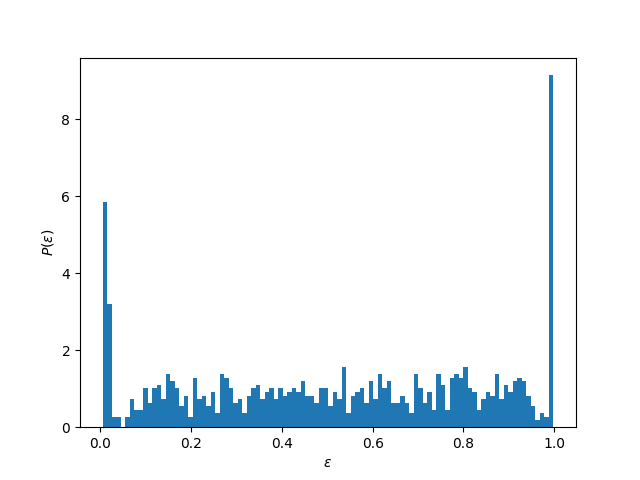

In [28]:
%matplotlib notebook

L_idx, l_idx, W_idx = 0, 0, 5
Energy_list = []
for dis in range(100):
    d = all_data[L_idx,l_idx,W_idx,dis,:,:]
    d = get_lists(flatten_data(d))
    Energy_list += list(d[EP_DMRG_IDX])
plt.hist(Energy_list, bins=100, density=True)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$P(\epsilon)$")
plt.show()

Let's look at a 2D plot of Entanglement entropy, log variance, $\left<S^{z}\right>$ vs $\epsilon$ and $W$ for a given disorder

<IPython.core.display.Javascript object>


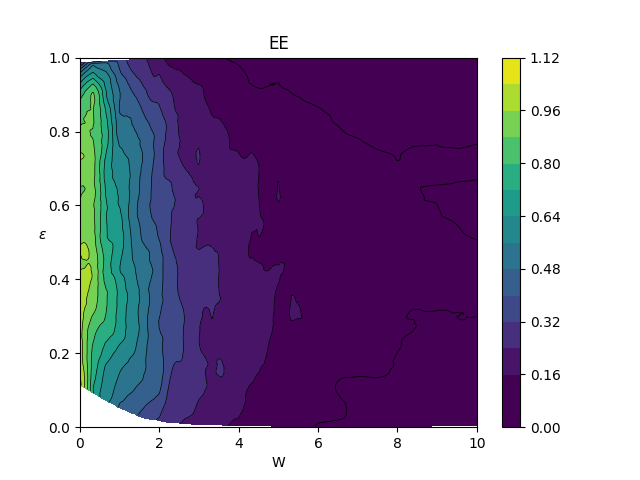

<IPython.core.display.Javascript object>


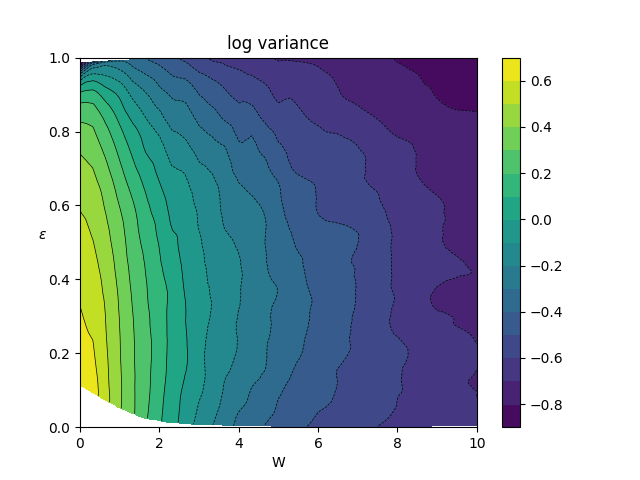

<IPython.core.display.Javascript object>


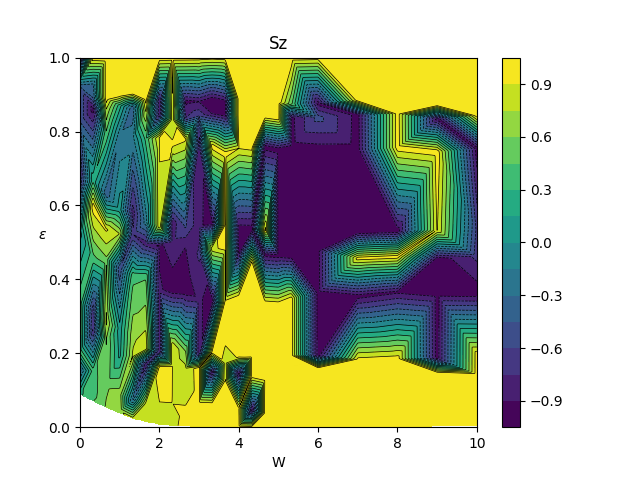

In [29]:
def plot2d(PARAM_IDX, title, L_idx=0, l_idx=0, d=-1, show_points=False, vmin=None, vmax=None):
    num_W, num_params = len(W_list), all_data.shape[-1]
    Nx, Ny = 500, 500
    param_grid = np.zeros((Nx, Ny))
    x_list = []
    y_list = []
    dis_list = [d] if d>=0 else range(num_dis)
    for dis in dis_list:
    
        flattened_data = all_data[L_idx,l_idx,:,dis,:,:].reshape([num_W*num_energies, num_params])
        pl = get_lists(flattened_data)

        Wp_list     = pl[W_IDX]          #x
        ep_list     = pl[EP_DMRG_IDX]    #y
        param_list  = pl[PARAM_IDX]      #z

        
        grid_x, grid_y = np.mgrid[0:10:Nx*1j, 0:1:Ny*1j]
        
        x_list     += list(Wp_list)
        y_list     += list(ep_list)
        param_grid += griddata(list(zip(Wp_list, ep_list)),  param_list, (grid_x, grid_y), 'linear')
    
    param_grid /= len(dis_list)
    plt.figure()
    #plt.imshow(param_grid.T, extent=(0,10,0,1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    plt.contour(grid_x, grid_y, param_grid, 15, linewidths=0.5, colors='k', vmin=vmin, vmax=vmax)
    plt.contourf(grid_x, grid_y, param_grid, 15, vmin=vmin, vmax=vmax)
    if show_points:
        print(len(x_list))
        print(len(y_list))
        print("")
        plt.scatter(x_list, y_list, c='r', marker='o', s=5, zorder=10)
    plt.ylabel(r"$\varepsilon$", rotation=0)
    plt.xlabel("W")
    plt.title(title)
    plt.colorbar()
    plt.show()
    return


plot2d(EE_IDX, "EE", L_idx=0, l_idx=0, d=-1, show_points=False, vmin=.15)
plot2d(LOGVAR_IDX, "log variance", L_idx=0, l_idx=0, d=-1, show_points=False)
plot2d(SZ_IDX, "Sz", L_idx=0, l_idx=0, d=0, show_points=False, vmin=-1, vmax=1)

Let's look at a horizontal slice of this plot. That is, we fix an energy level and look at the parameter as a function of W

<IPython.core.display.Javascript object>


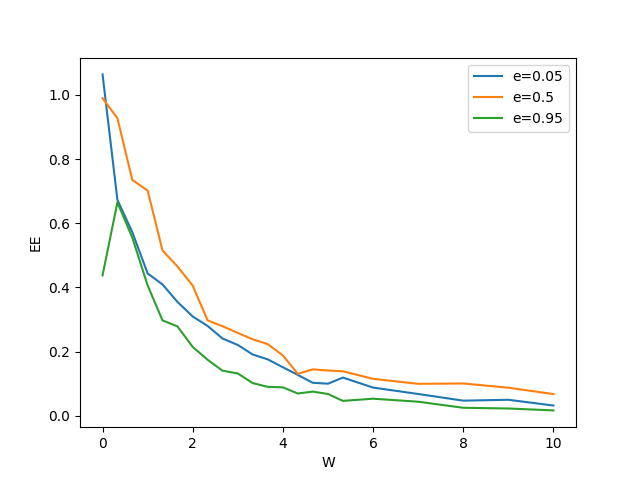

In [30]:
# plots for constant energy
%matplotlib notebook
for r in [0.05, 0.5, .95]:
    EE_mera = np.zeros(len(W_list))
    for W_idx, W in enumerate(W_list):
        W_data = all_data[:,:,W_idx,:,:,:]
        flattened = flatten_data(W_data)
        e_data = get_ep_data(flattened, r, tol=0.05)
        EE = np.mean(get_lists(e_data)[EE_IDX])
        EE_mera[W_idx] = EE
    plt.plot(W_list, EE_mera, label='e={}'.format(r))
plt.legend(loc='best')
plt.xlabel("W")
plt.ylabel("EE")
plt.show()

<IPython.core.display.Javascript object>


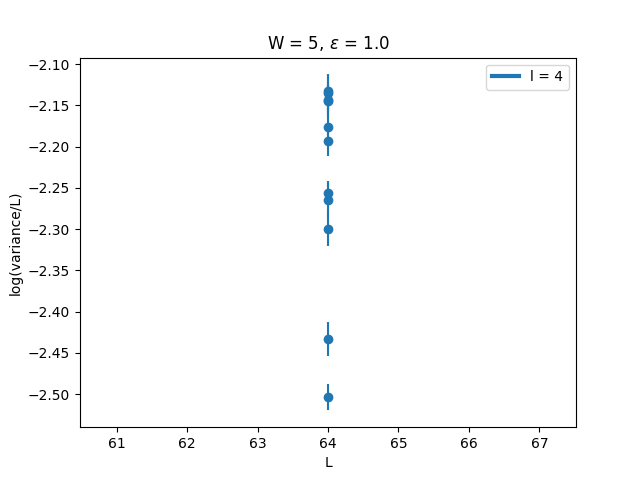

In [5]:
%matplotlib notebook
W_idx = 5
for ep in np.arange(11)/10:
    W = W_list[W_idx]
    for l_idx, l in enumerate(l_list):
        l_arr = all_data[:,l_idx,W_idx,:,:,:]
        logvar_list = []
        std_list = []
        for L_idx, L in enumerate(L_list):
            L_arr = flatten_data(l_arr[L_idx,:,:,:])
            logvars = get_lists(np.array(get_ep_data(L_arr, ep)))[LOGVAR_IDX]
            logvar_list.append(np.mean(logvars)-np.log10(L))
            std_list.append(np.std(logvars)/np.sqrt(len(logvars)))

        plt.errorbar(L_list, logvar_list, std_list, fmt='C{}o-'.format(l_idx),label="l = {}".format(l))
plt.title(r"W = {}, $\epsilon$ = {}".format(W, ep))
plt.xlabel("L")
plt.ylabel("log(variance/L)")
#plt.legend(loc='best')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color="C{}".format(l_idx), linewidth=3, linestyle='-') for l_idx in range(len(l_list))]
labels = ['l = {}'.format(l) for l in l_list]
plt.legend(lines, labels)
plt.show()
        
        

Now we Plot the distribution of the entanglement for fixed W, L, and l.

0.0908913908


<IPython.core.display.Javascript object>


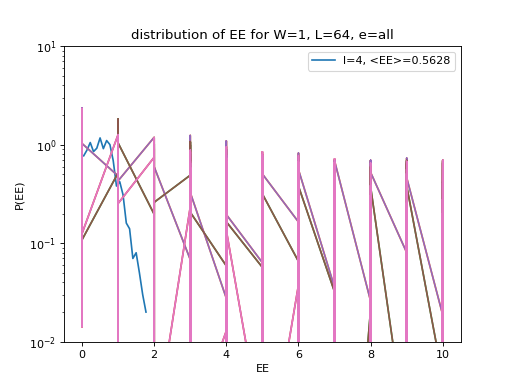

In [50]:
%matplotlib notebook
W_idx, L_idx = 1, 0
ep, tol =.5, .5

for l_idx, l in enumerate(l_list):
    l_arr = flatten_data(all_data[L_idx,l_idx,W_idx,:,:,:])
    l_arr = get_ep_data(l_arr, ep, tol=tol)
    EEs = get_lists(np.array(l_arr))[EE_IDX]
    hist, bin_edges = np.histogram(EEs, bins=20, density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    print(bin_edges[1] - bin_edges[0])
    plt.semilogy(bin_centers, hist, label="l={}, <EE>={:.4f}".format(l, np.mean(EEs)))
    if l == 5:
        print(len(EEs))

e = "all" if tol == .5 else ep
plt.title(r"distribution of EE for W={}, L={}, e={}".format(W_list[W_idx], L_list[L_idx], e))
plt.xlabel("EE")
plt.ylabel("P(EE)")
plt.ylim(.01, 10)
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


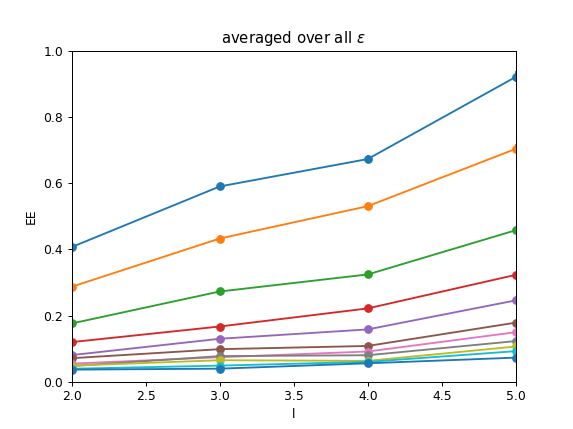

In [7]:
%matplotlib notebook
for W_idx, W in enumerate(W_list):
    ep, L_idx = .5, 2
    L_arr = all_data[L_idx,:,W_idx,:,:,:]
    EE_list = []
    std_list = []
    for l_idx, l in enumerate(l_list):
        l_arr = flatten_data(L_arr[l_idx,:,:])
        EEs = get_lists(np.array(get_ep_data(l_arr, ep, tol=.5)))[EE_IDX]
        EEs = EEs[~np.isnan(EEs)]
        EE_list.append(np.mean(EEs))
        std_list.append(np.std(EEs)/np.sqrt(len(EEs)))

    plt.errorbar(l_list, EE_list, std_list, fmt='o-', label="W = {}".format(W))
plt.title(r"averaged over all $\epsilon$".format(W))
plt.xlabel("l")
plt.ylabel("EE")
#plt.legend(loc='best')
plt.xlim(2,5)
plt.ylim(0,1)
plt.savefig("EEvl_L_{}.png".format(L_list[L_idx]))
plt.show()

<IPython.core.display.Javascript object>


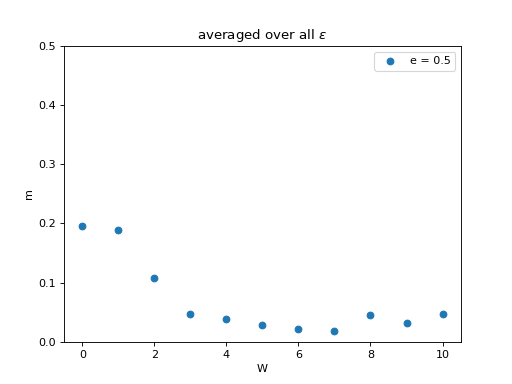

In [46]:
%matplotlib notebook
for ep in [.5]:
    ww_list = []
    slope_list = []
    for W_idx, W in enumerate(W_list):
        L_idx = 3
        L_arr = all_data[L_idx,:,W_idx,:,:,:]
        EE_list = []
        std_list = []
        x_list = []
        for l_idx, l in enumerate(l_list):

            l_arr = flatten_data(L_arr[l_idx,:,:])
            EEs = get_lists(np.array(get_ep_data(l_arr, ep, tol=.5)))[EE_IDX]
            if np.isnan(np.mean(EEs)):
                continue
            EE_list.append(np.mean(EEs))
            std_list.append(np.std(EEs)/np.sqrt(len(EEs)))
            x_list.append(l)
        #print(x_list)
        #print(EE_list)
        slope, _ = np.polyfit(x_list, EE_list, 1)
        #print(slope)
        #plt.scatter(W, slope, label='W = {}'.format(W))
        ww_list.append(W)
        slope_list.append(slope)
    plt.scatter(ww_list, slope_list, label='e = {}'.format(ep))
plt.title(r"averaged over all $\epsilon$".format(W))
plt.xlabel("W")
plt.ylabel("m")
plt.legend(loc='best')
#plt.xlim(3,5)
plt.ylim(0,.5)
plt.savefig("EEvl_L_{}.png".format(L_list[L_idx]))
plt.show()

<IPython.core.display.Javascript object>


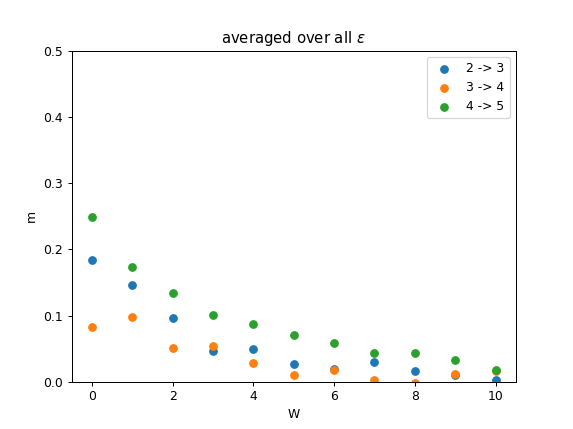

In [8]:
%matplotlib notebook
L_idx = 0
ep = .5
for i in range(len(l_list)-1):
    ww_list = []
    slope_list = []
    for W_idx, W in enumerate(W_list):
        L_arr = all_data[L_idx,:,W_idx,:,:,:]
        EE_list = []
        x_list = []
        for l_idx, l in enumerate(l_list[i:i+2]):
            l_idx += i
            l_arr = flatten_data(L_arr[l_idx,:,:])
            EEs = np.array(get_lists(np.array(get_ep_data(l_arr, ep, tol=.5)))[EE_IDX])
            EEs = EEs[~np.isnan(EEs)]
            EE_list.append(np.mean(EEs))
            x_list.append(l)
        slope, _ = np.polyfit(x_list, EE_list, 1)
        ww_list.append(W)
        slope_list.append(slope)
    plt.scatter(ww_list, slope_list, label='{} -> {}'.format(l_list[i], l_list[i+1]))
plt.title(r"averaged over all $\epsilon$".format(W))
plt.xlabel("W")
plt.ylabel("m")
plt.legend(loc='best')
#plt.xlim(3,5)
plt.ylim(0,.5)
plt.savefig("EEvl_L_{}.png".format(L_list[L_idx]))
plt.show()

<IPython.core.display.Javascript object>


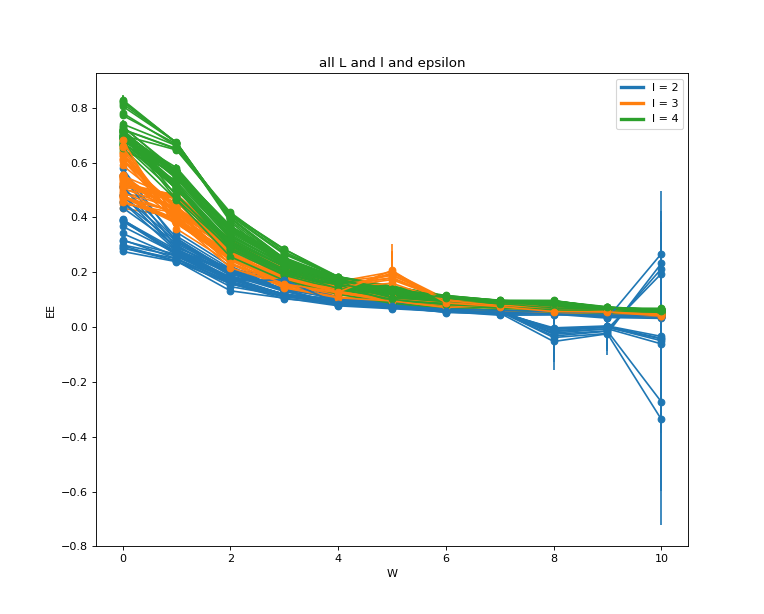

In [47]:
%matplotlib notebook
for ep in np.arange(11)/10:
    for L_idx, L in enumerate(L_list):
        for l_idx, l in enumerate(l_list):
            config = all_data[L_idx,l_idx,:,:,:,:]
            EE_list = []
            std_list = []
            for W_idx, W in enumerate(W_list):
                a = flatten_data(config[W_idx,:,:,:])
                try:
                    EEs = get_lists(np.array(get_ep_data(a, ep, tol = .5)))[EE_IDX]
                    EE_list.append(np.mean(EEs))
                    std_list.append(np.std(EEs)/np.sqrt(len(EEs)))
                except:
                    continue
            plt.errorbar(W_list, EE_list, std_list, fmt='C{}o-'.format(l_idx),label=r"L = {}, l = {}, $\epsilon$ = {}".format(L, l, ep))
plt.title("all L and l and epsilon")
plt.xlabel("W")
plt.ylabel("EE")

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color="C{}".format(l_idx), linewidth=3, linestyle='-') for l_idx in range(len(l_list))]
labels = ['l = {}'.format(l) for l in l_list]
plt.legend(lines, labels)
plt.show()


<IPython.core.display.Javascript object>


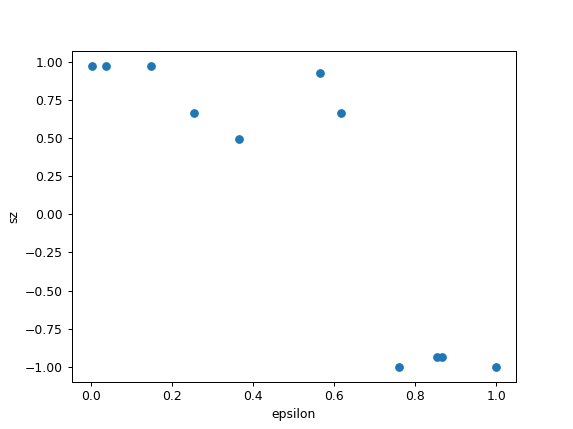

In [25]:
%matplotlib notebook
L_idx, l_idx, W_idx, dis = 0, 0, 3, 7
ep_data = get_lists(all_data[L_idx, l_idx, W_idx, dis,:,:].reshape(-1, all_data.shape[-1]))
sz_list = ep_data[SZ_IDX]
e_list = ep_data[EP_DMRG_IDX]

plt.scatter(e_list, sz_list)
plt.xlabel("epsilon")
plt.ylabel("sz")
plt.show()

<IPython.core.display.Javascript object>


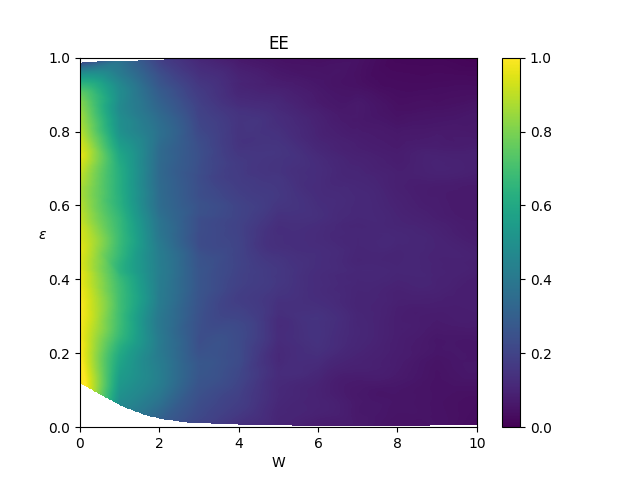

<IPython.core.display.Javascript object>


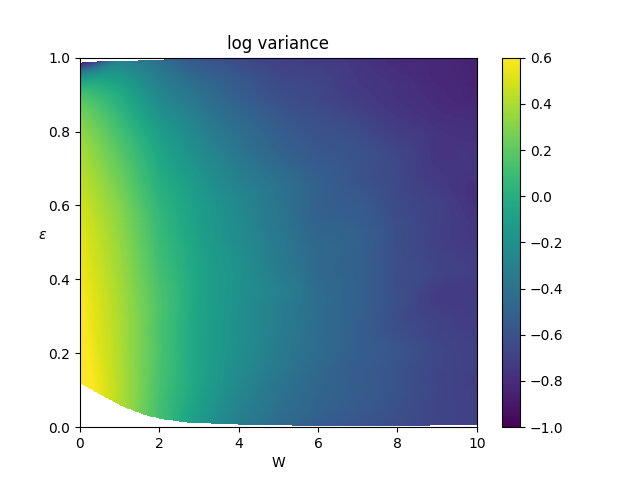

In [14]:
%matplotlib notebook
Nx, Ny = 500, 500
grid_x, grid_y = np.mgrid[0:10:Nx*1j, 0:1:Ny*1j]

EE_grid = np.zeros((Nx, Ny))
var_grid = np.zeros((Nx, Ny))


L_idx, l_idx = 0, 0
num_W, num_params = len(W_list), all_data.shape[-1]
for dis in range(num_dis):
    # E, var, EE, r, ep_mera, ep_dmrg, W, dis, e
    flattened_data = all_data[L_idx,l_idx,:,dis,:,:].reshape([num_W*num_energies, num_params])
    pl = get_lists(flattened_data)
    
    Wp_list  = pl[W_IDX]
    ep_list  = pl[EP_DMRG_IDX]
    EE_list  = pl[EE_IDX]
    var_list = pl[LOGVAR_IDX]
    
    EE_grid  += griddata(list(zip(Wp_list, ep_list)), EE_list,  (grid_x, grid_y), 'linear')
    var_grid += griddata(list(zip(Wp_list, ep_list)), var_list, (grid_x, grid_y), 'linear')

    #plt.scatter(W_list, ep_list, s=1)
grid_list = [EE_grid/num_dis, var_grid/num_dis]
#grid_list = [smooth_data2d(g, 3) for g in grid_list]

plt.figure()
plt.imshow(grid_list[0].T, extent=(0,10,0,1), origin='lower', aspect='auto', vmin=0, vmax=1)
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("EE")
plt.colorbar()

plt.figure()
plt.imshow(grid_list[1].T, extent=(0,10,0,1), origin='lower', aspect='auto',vmin=-1,vmax=.6)
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("log variance")
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


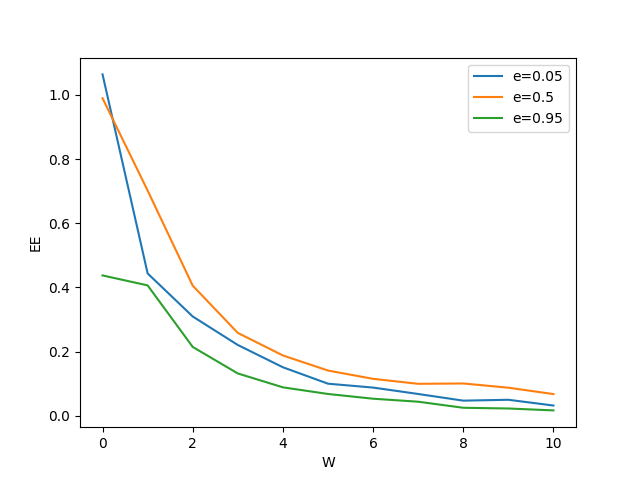

In [19]:
# plots for constant energy
%matplotlib notebook
for r in [0.05, 0.5, .95]:
    EE_mera = np.zeros(len(W_list))
    for W_idx, W in enumerate(W_list):
        W_data = all_data[:,:,W_idx,:,:,:]
        flattened = flatten_data(W_data)
        e_data = get_ep_data(flattened, r, tol=0.05)
        EE = np.mean(get_lists(e_data)[EE_IDX])
        EE_mera[W_idx] = EE
    plt.plot(W_list, EE_mera, label='e={}'.format(r))
plt.legend(loc='best')
plt.xlabel("W")
plt.ylabel("EE")
plt.show()

In [33]:
# plots for constant W
%matplotlib notebook
for W in [2, 3, 4, 5]:
    EE_mera = np.zeros(len(W_list))
    for W_idx, W in enumerate(W_list):
        W_data = all_data[:,:,W,:,:,:]
        flattened = flatten_data(W_data)
        e_data = get_ep_data(flattened, r, tol=0.05)
        EE = np.mean(get_lists(e_data)[EE_IDX])
        EE_mera[W_idx] = EE
    plt.plot(W_list, EE_mera, label='e={}'.format(r))
plt.legend(loc='best')
plt.xlabel("W")
plt.ylabel("EE")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

l = 2, 3, 4, 5, 6

L = 16, 32, 64, 128

EE vs W for various epsilon

variance vs L for various l

average Sz vs epsilon, where the average is over a bunch of energies near a given epsilon

geometry
